# README
# This Jupyter notebook contains the solution for Problems 3.7 and 3.9 from *Artificial Intelligence: A Modern Approach (3rd Edition)*.
# It includes analysis, explanations, and Python code implementations.

# Task Division

# Jason R. Gutierrez - Programming and Debugging 
# Diego A. Green - Programming and Debugging
# Abel Martinez - Programming and Report
# Nelson Nin - Programming and Presentation

# Abstract 

In previous work, reflex agents were utilized due to their simplicity, as they make decisions solely based on immediate perceptions. While effective in small and well-defined environments such as the vacuum world, these agents struggle in large or complex environments where storing a complete map or learning an extensive state space is impractical. To address these limitations, goal-based agents consider future actions and their desirability, enabling more strategic decision-making.

This study focuses on problem-solving using search-based goal-driven agents. These agents perceive the environment as a collection of discrete states, without an explicit internal structure visible to problem-solving algorithms. More advanced goal-based agents that incorporate structured or factored representations are classified as planning agents.

To evaluate search-based problem-solving, various general-purpose search algorithms are applied. These include uninformed search algorithms, which rely solely on problem definitions to find solutions. While capable of solving any solvable problem, these methods tend to be inefficient. In contrast, informed search algorithms leverage heuristic guidance to improve search efficiency by directing exploration toward promising solution paths. This analysis aims to assess and visualize the effectiveness of informed search methods in complex problem-solving scenarios.

# Introduction 

In deterministic, observable, static, and fully known environments, agents can choose actions using various strategies. Search processes involve generating sequences of actions that guide the agent toward achieving its goals. Before initiating a search, the agent must clearly define the problem by specifying the initial state, available actions, a transition model, a goal test, and a path cost function. Search algorithms treat states and actions as discrete entities without analyzing their internal structures [1].

There are two main types of search algorithms: uninformed and informed. Uninformed search algorithms, such as breadth-first search, uniform-cost search, and depth-first search, rely solely on the problem definition without additional guidance. In contrast, informed search algorithms, like greedy best-first search and A* search, use heuristics to estimate solution costs, enabling more efficient search strategies [3]. The performance of heuristic-based algorithms largely depends on the quality of the heuristic function, which is often derived by simplifying the problem representation [4].

# Exercise 3.7 

Consider the problem of finding the shortest path between two points in a plane with convex polygonal obstacles, as shown in Figure 3.31. This idealizes the navigation problem a robot faces in a crowded environment.

a. If the state space consists of all positions (x, y) in the plane, how many states are there? How many paths lead to the goal?

There would be an infinite number of states since each possible point (x,y) on the plane represents a distinct state, resulting in an unlimited number of possible paths to the goal. This number of possibilities arises because movement across the plane is continuous, meaning that even the smallest variations in position create entirely new states.

b. Explain briefly why the shortest path from one polygon vertex to another must consist of straight-line segments connecting some of the polygon vertices. Define a good state space now. How large is this state space?

When moving across a two-dimensional plane, the most efficient route between two points is typically a straight line. If there are no obstacles obstructing the path between two vertices, the shortest route is a single uninterrupted line segment. However, when obstacles are present, the shortest path is composed of multiple connected segments that navigate around these obstacles by passing through specific polygon vertices. Consequently, the state space should be defined by these polygon vertices, including both the starting and goal positions, resulting in a total of 35 vertices.

c. Define the necessary functions to implement the search problem, including an ACTIONS function that takes a vertex and returns all vertices reachable in a straight line. Use straight-line distance as the heuristic function.

To implement the search problem, the necessary functions must be defined, including an ACTIONS function and a heuristic function based on straight-line distance.

The ACTIONS function takes a given vertex as input and returns all directly reachable vertices connected by straight-line segments.
It ensures that connections are valid, considering only vertices that can be reached without crossing obstacles.
It accounts for vertices that belong to the same polygon structure.
The heuristic function will be based on the Euclidean distance between points, providing an estimate of the cost to reach the goal.

To efficiently solve the polygon navigation problem, the following search algorithms will be applied:

Breadth-first search (BFS): Explores all possible paths systematically by expanding the shallowest nodes first.
Best-first search: Utilizes heuristics to prioritize expanding the most promising nodes based on estimated cost.
Uniform-cost search (UCS): Expands nodes based on the lowest path cost, ensuring optimal solutions when costs vary.
By integrating these search strategies, we can effectively model and solve the problem of navigating a polygonal environment while avoiding obstacles.

In [3]:
import matplotlib.pyplot as plt
import random
import heapq
import math
import sys
from collections import defaultdict, deque, Counter
from itertools import combinations


class SearchProblem:
    """Base class for defining search problems. Subclass this to define:
    - Available actions from each state.
    - State transitions.
    - Optional: Custom goal test and heuristics."""

    def __init__(self, start_state=None, goal_state=None, **kwargs):
        self.initial = start_state
        self.goal = goal_state
        self.__dict__.update(**kwargs)

    def available_moves(self, state):
        raise NotImplementedError("Define available moves for each state.")

    def next_state(self, current_state, move):
        raise NotImplementedError("Define how each move transitions between states.")

    def goal_reached(self, state):
        return state == self.goal

    def move_cost(self, state, action, next_state):
        return 1

    def heuristic(self, node):
        return 0

    def __str__(self):
        return f"{type(self).__name__}(start={self.initial}, goal={self.goal})"


class TreeNode:
    """Represents a node in the search tree with parent tracking."""

    def __init__(self, state, parent_node=None, action_taken=None, total_cost=0):
        self.state = state
        self.parent = parent_node
        self.action = action_taken
        self.path_cost = total_cost

    def __repr__(self):
        return f"<Node {self.state}>"

    def depth(self):
        return 0 if self.parent is None else 1 + self.parent.depth()

    def __lt__(self, other):
        return self.path_cost < other.path_cost


# Special markers for search outcomes
search_failure = TreeNode('no_solution', total_cost=math.inf)
search_cutoff = TreeNode('cutoff', total_cost=math.inf)


def expand_node(problem, node):
    """Expands a node into its child nodes by applying all valid moves."""
    current = node.state
    for move in problem.available_moves(current):
        next_s = problem.next_state(current, move)
        move_cost = node.path_cost + problem.move_cost(current, move, next_s)
        yield TreeNode(next_s, node, move, move_cost)


def actions_from_root(node):
    """Traces back the series of actions taken to reach the current node."""
    if node.parent is None:
        return []
    return actions_from_root(node.parent) + [node.action]


def states_from_root(node):
    """Traces back the sequence of states from the root to this node."""
    if node in (search_cutoff, search_failure, None):
        return []
    return states_from_root(node.parent) + [node.state]


In [4]:
class MinPriorityQueue:
    """Custom priority queue: always pops the item with the smallest key value."""

    def __init__(self, initial_items=(), score_function=lambda x: x):
        self.score_function = score_function
        self.heap_data = []  # stores (priority_score, item) tuples
        for itm in initial_items:
            self.insert(itm)

    def insert(self, itm):
        """Insert a new item with its priority score."""
        entry = (self.score_function(itm), itm)
        heapq.heappush(self.heap_data, entry)

    def remove(self):
        """Remove and return the item with the smallest priority score."""
        return heapq.heappop(self.heap_data)[1]

    def peek(self):
        """Return the item with the smallest score without removing it."""
        return self.heap_data[0][1]

    def __len__(self):
        return len(self.heap_data)

# Simple queue structures for different search strategies
FirstInFirstOutQueue = deque
LastInFirstOutQueue = list

In [5]:
def bfs_search(problem_instance):
    """Performs a breadth-first search, exploring shallowest nodes first."""
    start_node = TreeNode(problem_instance.initial)
    if problem_instance.goal_reached(problem_instance.initial):
        return start_node

    frontier_queue = FirstInFirstOutQueue([start_node])
    visited_states = {problem_instance.initial}

    while frontier_queue:
        current_node = frontier_queue.pop()
        for next_node in expand_node(problem_instance, current_node):
            state = next_node.state
            if problem_instance.goal_reached(state):
                return next_node
            if state not in visited_states:
                visited_states.add(state)
                frontier_queue.appendleft(next_node)

    return search_failure


def path_cost(node):
    return node.path_cost


def greedy_best_first_search(problem_instance, priority_func):
    """Generic best-first search with custom priority function."""
    start_node = TreeNode(problem_instance.initial)
    open_set = MinPriorityQueue([start_node], score_function=priority_func)
    visited = {problem_instance.initial: start_node}

    while open_set:
        current = open_set.remove()
        if problem_instance.goal_reached(current.state):
            return current

        for next_node in expand_node(problem_instance, current):
            state = next_node.state
            if state not in visited or next_node.path_cost < visited[state].path_cost:
                visited[state] = next_node
                open_set.insert(next_node)

    return search_failure


def uniform_cost_search(problem_instance):
    """Uniform-cost search, always expanding the cheapest node first."""
    return greedy_best_first_search(problem_instance, priority_func=path_cost)

In [6]:
class MapRouteProblem(SearchProblem):
    """Defines a routing problem on a map structure. States are map locations; actions are adjacent locations."""

    def available_moves(self, current_location):
        """Returns neighboring locations from the current location."""
        return self.map.neighbors[current_location]

    def next_state(self, current_location, chosen_move):
        """Return the resulting state after taking an action."""
        return chosen_move if chosen_move in self.map.neighbors[current_location] else current_location

    def move_cost(self, from_location, action, to_location):
        """Returns the travel distance between two connected locations."""
        return self.map.distances[from_location, to_location]

    def heuristic(self, current_node):
        """Estimates cost from current location to goal using straight-line distance."""
        positions = self.map.locations
        return euclidean_distance(positions[current_node.state], positions[self.goal])


def euclidean_distance(pointA, pointB):
    """Calculates straight-line (Euclidean) distance between two points."""
    return sum((a - b) ** 2 for a, b in zip(pointA, pointB)) ** 0.5

In [10]:
class WorldMap:
    """Represents a geographical map as a network of connected locations and distances."""

    def __init__(self, connections, city_coords=None, directed=False):
        if not hasattr(connections, 'items'):
            connections = {pair: 1 for pair in connections}
        if not directed:
            for (loc1, loc2) in list(connections):
                connections[loc2, loc1] = connections[loc1, loc2]

        self.distances = connections
        self.neighbors = create_neighbor_map(connections)
        self.locations = city_coords or defaultdict(lambda: (0, 0))


def create_neighbor_map(pairs):
    """Creates a dictionary mapping each location to a list of its neighboring locations."""
    neighbor_map = defaultdict(list)
    for key, value in pairs:
        neighbor_map[key].append(value)
    return neighbor_map

d. Apply one or more of the algorithms from this chapter to solve a variety of problems in this domain and comment on their performance.

When applying uniform-cost and breadth-first search to the vertex map, both algorithms generated different routes but covered the same total distance when all edges had equal weights. However, when realistic distances based on Cartesian coordinates were introduced, both algorithms converged on the same shortest path, highlighting their effectiveness in this scenario.

In [11]:
demo_map = WorldMap(
    {('Start', 'V1'): 1, ('Start', 'V4'): 1, ('Start', 'V8'): 1, ('V1', 'V5'): 1, ('V1', 'V11'): 1,
     ('V4', 'V3'): 1, ('V5', 'V12'): 1, ('V8', 'V7'): 1, ('V7', 'V15'): 1, ('V12', 'V16'): 1,
     ('V16', 'V15'): 1, ('V15', 'V23'): 1, ('V11', 'V14'): 1, ('V11', 'V17'): 1, ('V14', 'V23'): 1,
     ('V23', 'V22'): 1, ('V22', 'V32'): 1, ('V17', 'V19'): 1, ('V19', 'V29'): 1, ('V3', 'V24'): 1,
     ('V24', 'V29'): 1, ('V3', 'V26'): 1, ('V26', 'V27'): 1, ('V27', 'V30'): 1, ('V30', 'V29'): 1,
     ('V29', 'V33'): 1, ('V33', 'V32'): 1, ('V32', 'Goal'): 1, ('V30', 'Goal'): 1}
)

example_route_problem = MapRouteProblem('Start', 'Goal', map=demo_map)

In [12]:
print(states_from_root(uniform_cost_search(example_route_problem)))

['Start', 'V4', 'V3', 'V24', 'V29', 'V30', 'Goal']


In [13]:
print(states_from_root(bfs_search(example_route_problem)))

['Start', 'V4', 'V3', 'V24', 'V29', 'V30', 'Goal']


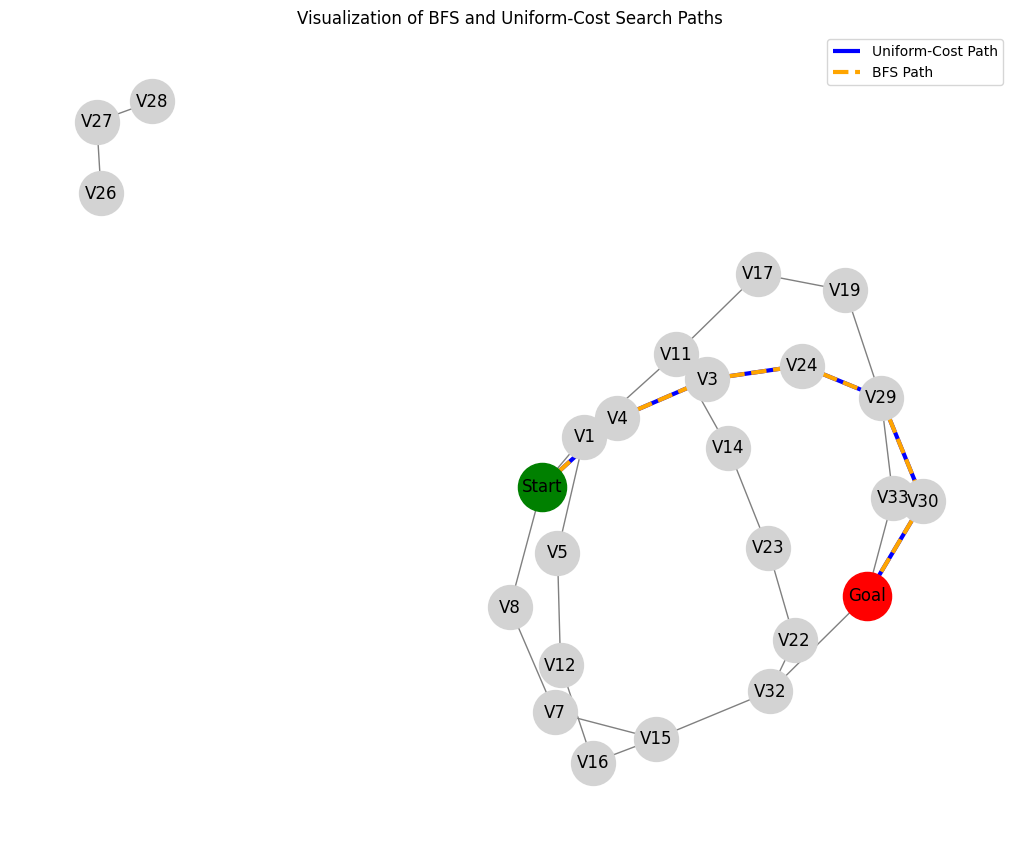

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

edges = [
    ('Start', 'V1'), ('Start', 'V4'), ('Start', 'V8'), ('V1', 'V5'), ('V1', 'V11'),
    ('V4', 'V3'), ('V5', 'V12'), ('V8', 'V7'), ('V7', 'V15'), ('V12', 'V16'),
    ('V16', 'V15'), ('V15', 'V32'), ('V11', 'V14'), ('V11', 'V17'), ('V14', 'V23'),
    ('V23', 'V22'), ('V22', 'V32'), ('V17', 'V19'), ('V19', 'V29'), ('V3', 'V24'),
    ('V24', 'V29'), ('V29', 'V30'), ('V26', 'V27'), ('V27', 'V28'), ('V30', 'V29'),
    ('V29', 'V33'), ('V32', 'Goal'), ('V33', 'Goal'), ('V30', 'Goal')
]

ucs_path = states_from_root(uniform_cost_search(example_route_problem))
bfs_path = states_from_root(bfs_search(example_route_problem))

G = nx.Graph()
G.add_edges_from(edges)

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_color='lightgray', edge_color='gray', node_size=1000)

nx.draw_networkx_edges(G, pos, edgelist=list(zip(ucs_path, ucs_path[1:])), edge_color='blue', width=3, label='Uniform-Cost Path')
nx.draw_networkx_edges(G, pos, edgelist=list(zip(bfs_path, bfs_path[1:])), edge_color='orange', width=3, style='dashed', label='BFS Path')

nx.draw_networkx_nodes(G, pos, nodelist=['Start'], node_color='green', node_size=1200)
nx.draw_networkx_nodes(G, pos, nodelist=['Goal'], node_color='red', node_size=1200)

plt.legend()
plt.title("Visualization of BFS and Uniform-Cost Search Paths")
plt.axis('off')
plt.show()


For this exercise, since the distances were the same, the two searches navigated through different routes. 

![image.png](attachment:image.png)

Figure 2. The search algorithms' path

A Cartesian plane was constructed to represent the environment, mapping out the coordinates and distances between vertices. The code below showcases the finalized plane.

In [14]:
figures2 = WorldMap(
    {('S', 'V1'): 3.354, ('S', 'V4'): 2.5, ('S', 'V8'): 12, ('V1', 'V5'): 5.59, ('V1', 'V11'): 13.153,
     ('V4', 'V3'): 16, ('V5', 'V12'): 9.01, ('V8', 'V7'): 7.81, ('V7', 'V15'): 13, ('V12', 'V16'): 4.61,
     ('V16', 'V15'): 4.03, ('V15', 'V23'): 4.16, ('V11', 'V14'): 11.4, ('V11', 'V17'): 4.472, ('V14', 'V23'): 2.236,
     ('V23', 'V22'): 6, ('V22', 'V32'): 4, ('V17', 'V19'): 6.403, ('V19', 'V29'): 6.708, ('V3', 'V24'): 9.434,
     ('V24', 'V29'): 5, ('V3', 'V26'): 11, ('V26', 'V27'): 4.123, ('V27', 'V30'): 6, ('V30', 'V29'): 3.162,
     ('V29', 'V33'): 9, ('V33', 'V32'): 3.162, ('V32', 'G'): 2, ('V30', 'VG'): 11.18},

    {'S': (8.5, 3), 'V1': (10, 6), 'V2': (26, 6), 'V3': (26, 1), 'V4': (10, 1), 'V5': (15, 8.5),
     'V6': (18, 15), 'V7': (14, 20), 'V8': (8, 15), 'V9': (9.5, 8.5), 'V10': (18, 8), 'V11': (23, 8),
     'V12': (20, 16), 'V13': (23, 13), 'V14': (30, 17), 'V15': (27, 20), 'V16': (23, 19.5), 'V17': (27, 10),
     'V18': (28, 3), 'V19': (32, 6), 'V20': (31, 9), 'V21': (37, 9), 'V22': (37, 19), 'V23': (31, 19),
     'V24': (34, 6), 'V25': (34, 2), 'V26': (37, 1), 'V27': (41, 2), 'V28': (41, 6), 'V29': (38, 9),
     'V30': (41, 8), 'V31': (42, 17.5), 'V32': (41, 19), 'V33': (38, 18), 'G': (43, 19)}
)

r0 = MapRouteProblem('S', 'G', map=figures2)


In [15]:
print(states_from_root(uniform_cost_search(r0)))

['S', 'V1', 'V11', 'V14', 'V23', 'V22', 'V32', 'G']


In [16]:
print(states_from_root(bfs_search(r0)))

['S', 'V1', 'V11', 'V14', 'V23', 'V22', 'V32', 'G']


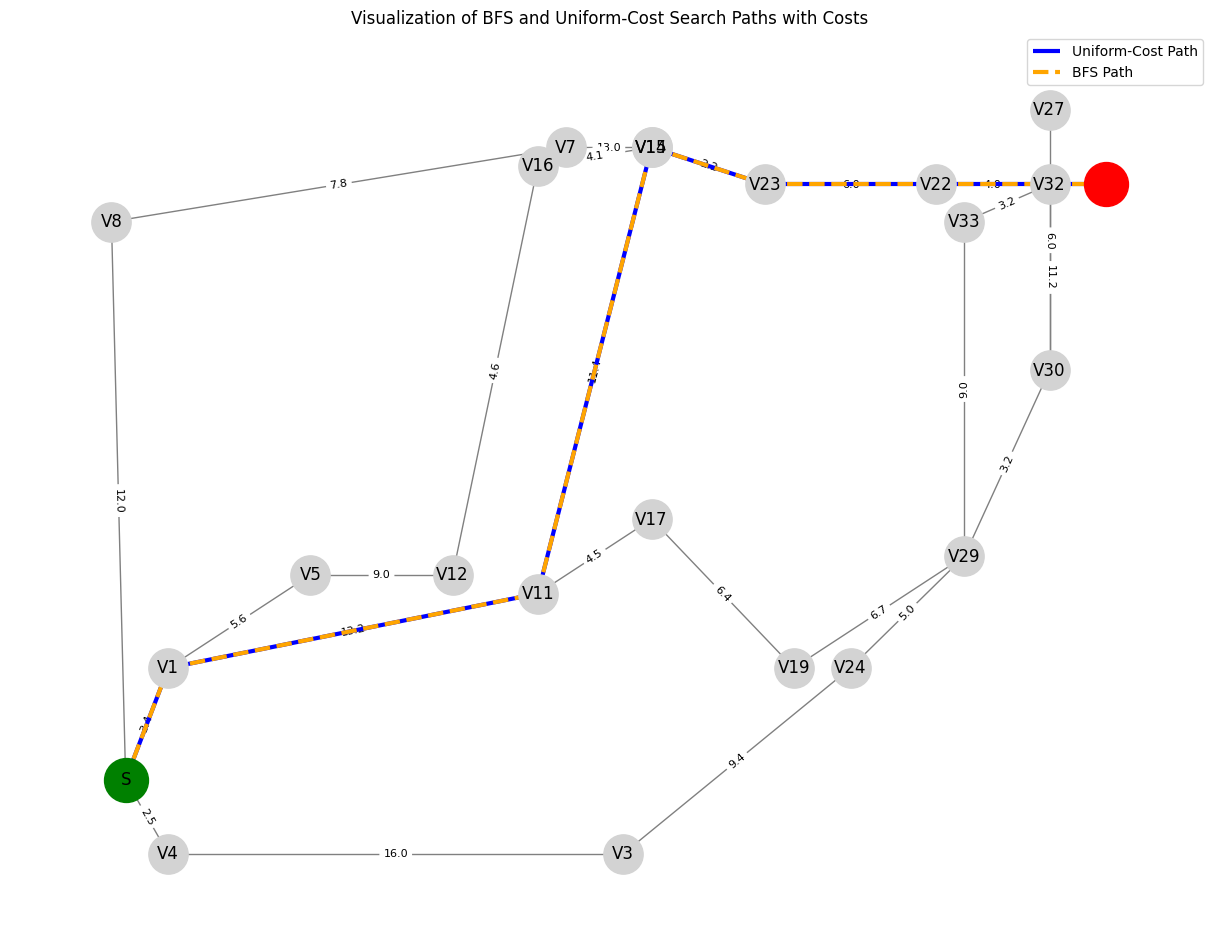

In [30]:
import networkx as nx
import matplotlib.pyplot as plt

edges_weighted = {
    ('S', 'V1'): 3.354, ('S', 'V4'): 2.5, ('S', 'V8'): 12, ('V1', 'V5'): 5.59, ('V1', 'V11'): 13.153,
    ('V4', 'V3'): 16, ('V5', 'V12'): 9.01, ('V8', 'V7'): 7.81, ('V7', 'V15'): 13, ('V12', 'V16'): 4.61,
    ('V16', 'V15'): 4.083, ('V11', 'V14'): 11.4, ('V11', 'V17'): 4.472, ('V14', 'V23'): 2.236,
    ('V23', 'V22'): 6, ('V22', 'V32'): 4, ('V17', 'V19'): 6.403, ('V19', 'V29'): 6.708, ('V3', 'V24'): 9.434,
    ('V24', 'V29'): 5, ('V27', 'V30'): 6, ('V30', 'V29'): 3.162,
    ('V29', 'V33'): 9, ('V33', 'V32'): 3.162, ('V30', 'V32'): 11.18
}

node_positions = {
    'S': (8.5, 3), 'V1': (10, 6), 'V2': (26, 6), 'V3': (26, 1), 'V4': (10, 1), 'V5': (15, 8.5),
    'V6': (18, 15), 'V7': (24, 20), 'V8': (8, 18), 'V9': (9.5, 8.5), 'V10': (18, 8), 'V11': (23, 8),
    'V12': (20, 8.5), 'V13': (13.6, 11.5), 'V14': (27, 20), 'V15': (27, 20), 'V16': (23, 19.5),
    'V17': (27, 10), 'V18': (24, 36), 'V19': (32, 6), 'V20': (31, 9), 'V21': (37, 9), 'V22': (37, 19),
    'V23': (31, 19), 'V24': (34, 6), 'V25': (34, 9), 'V26': (37, 21), 'V27': (41, 21), 'V28': (41, 6),
    'V29': (38, 9), 'V30': (41, 14), 'V31': (42, 5.5), 'V32': (41, 19), 'V33': (38, 18), 'G': (43, 19)
}

ucs_path = states_from_root(uniform_cost_search(r0))
bfs_path = states_from_root(bfs_search(r0))

G = nx.Graph()
for (start, end), weight in edges_weighted.items():
    G.add_edge(start, end, weight=weight)

plt.figure(figsize=(12, 9))

nx.draw(G, pos=node_positions, with_labels=True, node_color='lightgray', edge_color='gray', node_size=800)

nx.draw_networkx_edge_labels(
    G, pos=node_positions,
    edge_labels={(u, v): f'{d["weight"]:.1f}' for u, v, d in G.edges(data=True)},
    font_size=8
)

nx.draw_networkx_edges(
    G, pos=node_positions,
    edgelist=list(zip(ucs_path, ucs_path[1:])),
    edge_color='blue', width=3, label='Uniform-Cost Path'
)

nx.draw_networkx_edges(
    G, pos=node_positions,
    edgelist=list(zip(bfs_path, bfs_path[1:])),
    edge_color='orange', width=3, style='dashed', label='BFS Path'
)

nx.draw_networkx_nodes(G, pos=node_positions, nodelist=['S'], node_color='green', node_size=1000)
nx.draw_networkx_nodes(G, pos=node_positions, nodelist=['G'], node_color='red', node_size=1000)

plt.title("Visualization of BFS and Uniform-Cost Search Paths with Costs")
plt.legend()
plt.axis('off')
plt.show()


For this exercise, where the distance values were modified, the algorithms still followed the same path.


The missionaries and cannibals problem states that three missionaries and three cannibals are on one side of a river with a boat that can carry one or two people. Find a way to transport all individuals to the other side without ever leaving a group of missionaries outnumbered by cannibals on either side.

a. Formulate the problem precisely, making only necessary distinctions for a valid solution. Draw a complete state space diagram.

The state space diagram has been drawn to show all valid states and transitions.

b. Implement and solve the problem optimally using a suitable search algorithm. Is it a good idea to check for repeated states?

The problem was implemented using a Depth-First Search (DFS) approach. Repeated state checking is crucial to avoid infinite loops and redundant paths. The implementation involves interactive input to simulate moves and check conditions to ensure missionaries are never outnumbered.

In [ ]:
def display_state(left_missionaries, left_cannibals, right_missionaries, right_cannibals, direction):
    """Displays the current state of the river crossing problem."""
    boat = "-->" if direction == "right" else "<--"
    print("\n")
    print(f"M " * left_missionaries + f"C " * left_cannibals + f"| {boat} | " + f"M " * right_missionaries + f"C " * right_cannibals + "\n")


def is_valid_trip(missionaries, cannibals, left_missionaries, left_cannibals, right_missionaries, right_cannibals, direction):
    """Validates the user's move based on the rules of the problem."""
    if missionaries == 0 and cannibals == 0:
        print("The boat cannot cross empty.")
        return False
    if missionaries + cannibals > 2:
        print("The boat cannot carry more than 2 people.")
        return False

    if direction == "right":
        return (missionaries <= left_missionaries) and (cannibals <= left_cannibals)
    else:
        return (missionaries <= right_missionaries) and (cannibals <= right_cannibals)


def is_missionaries_eaten(missionaries, cannibals):
    """Checks if the missionaries have been eaten."""
    return cannibals > missionaries > 0


def make_trip(left_missionaries, left_cannibals, right_missionaries, right_cannibals, direction):
    """Handles user input and updates the state of the game."""
    while True:
        print(f"\n{'Left' if direction == 'right' else 'Right'} side -> {'Right' if direction == 'right' else 'Left'} side")
        try:
            missionaries = int(input("Enter the number of missionaries for the trip => "))
            cannibals = int(input("Enter the number of cannibals for the trip => "))

            if is_valid_trip(missionaries, cannibals, left_missionaries, left_cannibals, right_missionaries, right_cannibals, direction):
                break
            else:
                print("Invalid move. Please enter a new input.")

        except ValueError:
            print("Invalid input. Please enter a number.")

    if direction == "right":
        left_missionaries -= missionaries
        left_cannibals -= cannibals
        right_missionaries += missionaries
        right_cannibals += cannibals
    else:
        left_missionaries += missionaries
        left_cannibals += cannibals
        right_missionaries -= missionaries
        right_cannibals -= cannibals

    return left_missionaries, left_cannibals, right_missionaries, right_cannibals


# ----- Main Execution -----
def main():
    print("\nExercise 3.9")

    left_missionaries, left_cannibals = 3, 3
    right_missionaries, right_cannibals = 0, 0
    trips = 0

    print("\nInitial State:")
    print("\nM M M C C C | --- | \n")

    try:
        while True:
            # Move from left to right
            left_missionaries, left_cannibals, right_missionaries, right_cannibals = make_trip(
                left_missionaries, left_cannibals, right_missionaries, right_cannibals, direction="right"
            )
            display_state(left_missionaries, left_cannibals, right_missionaries, right_cannibals, "right")
            trips += 1

            if is_missionaries_eaten(left_missionaries, left_cannibals) or is_missionaries_eaten(right_missionaries, right_cannibals):
                print("The cannibals ate the missionaries:\nEnd of the exercise.")
                break

            if left_missionaries == 0 and left_cannibals == 0:
                print("You have successfully completed the exercise.")
                print("Total trips:", trips)
                break

            # Move from right to left
            left_missionaries, left_cannibals, right_missionaries, right_cannibals = make_trip(
                left_missionaries, left_cannibals, right_missionaries, right_cannibals, direction="left"
            )
            display_state(left_missionaries, left_cannibals, right_missionaries, right_cannibals, "left")
            trips += 1

            if is_missionaries_eaten(left_missionaries, left_cannibals) or is_missionaries_eaten(right_missionaries, right_cannibals):
                print("The cannibals ate the missionaries:\nEnd of the exercise.")
                break

    except EOFError:
        print("\nInvalid input, try another move.")


# Run the game
if __name__ == "__main__":
    main()



Exercise 3.9

Initial State:

M M M C C C | --- | 


Left side -> Right side


M M C C | --> | M C 


Right side -> Left side
The boat cannot cross empty.
Invalid move. Please enter a new input.

Right side -> Left side
Invalid input. Please enter a number.

Right side -> Left side
Invalid input. Please enter a number.

Right side -> Left side
Invalid input. Please enter a number.

Right side -> Left side
Invalid input. Please enter a number.

Right side -> Left side
Invalid input. Please enter a number.

Right side -> Left side
Invalid input. Please enter a number.

Right side -> Left side
Invalid input. Please enter a number.

Right side -> Left side
Invalid input. Please enter a number.

Right side -> Left side
Invalid input. Please enter a number.

Right side -> Left side
Invalid input. Please enter a number.

Right side -> Left side
Invalid input. Please enter a number.

Right side -> Left side
Invalid input. Please enter a number.

Right side -> Left side
Invalid input. Please e

c. Why do you think people find this puzzle difficult, given that the state space is so simple?

Although the state space is relatively simple, the problem presents a significant challenge due to the need for strategic planning to prevent missionaries from being outnumbered. Successfully solving it requires careful coordination of multiple agents (missionaries and cannibals) while anticipating future outcomes. Its combinatorial complexity and the necessity for forward-thinking make it a cognitively demanding task.

## Discussion



In the first exercise, we saw that the state space includes every possible (x,y) position, which means there are infinitely many states and paths. The shortest path is just a series of straight-line segments between polygon vertices. By limiting the state space to only the polygon vertices, the problem becomes way simpler.

Both uniform-cost search and breadth-first search found optimal solutions. When all distances were the same, they came up with different paths that had the same total cost. But when we used actual distances, both algorithms ended up picking the same shortest path [2].

In the second exercise, DFS was used to explore different move combinations. The interactive simulation made it clear how important planning ahead is to avoid unsafe states. This exercise showed how searching through states and avoiding repeats is key to finding the best solution.

# Conclusion


These exercises highlighted the importance of adapting different problem-solving strategies based on the nature of the problem. Simple state-to-action mappings can be effectively handled by reflex agents, making them suitable for straightforward tasks. However, more complex scenarios require goal-based agents, which take future consequences into account when making decisions. Problem-solving agents rely on basic state representations to navigate through a predefined space, whereas planning agents often require more sophisticated structures to anticipate multiple steps ahead.

Through these exercises, we observed how search algorithms play a crucial role in finding optimal solutions. While breadth-first search ensures all possible paths are explored systematically, uniform-cost search prioritizes paths based on cost, and depth-first search allows for deep exploration of possible moves. Each algorithm has its strengths and weaknesses, and their effectiveness depends on factors like state complexity, cost functions, and problem constraints.

In summary, problem-solving is a dynamic and multifaceted process that requires strategic decision-making, careful state representation, and the appropriate application of algorithms. As seen in these exercises, even problems with simple rules can become complex due to the number of possible states and constraints involved. By understanding and leveraging the right search techniques, heuristic functions, and planning methods, we can navigate challenges efficiently and work towards finding optimal solutions. This reinforces the importance of algorithmic thinking and structured approaches in tackling real-world decision-making problems.

## References 

[1] S. Russell and P. Norvig, Artificial Intelligence: A Modern Approach, 4th ed. Pearson, 2021.

[2] UC Berkeley, "aimacode," GitHub Repository, Available: https://github.com/aimacode. Accessed: Mar. 17, 2025.

[3] N. J. Nilsson, Artificial Intelligence: A New Synthesis. Morgan Kaufmann, 1998.

[4] M. Ghallab, D. Nau, and P. Traverso, Automated Planning: Theory and Practice. Morgan Kaufmann, 2004.